In [1]:
from pyspark.sql.functions import concat_ws, col
from pyspark.sql.functions import avg
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, sum
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

In [2]:
df = spark.read.csv("gs://bvktest1/70_percent_train_data.csv",
                    header=True,
                    inferSchema=True)

In [3]:
from pyspark.sql.functions import col, date_format, to_timestamp

df = df.withColumn("Brew_Date", to_timestamp(col("Brew_Date"), "yyyy-MM-dd HH:mm:ss"))

# Extract month, day, year, and time from Brew_Date
df = df.withColumn("Month", date_format(col("Brew_Date"), "MM")) \
       .withColumn("Day", date_format(col("Brew_Date"), "dd")) \
       .withColumn("Year", date_format(col("Brew_Date"), "yyyy")) \
       .withColumn("Time", date_format(col("Brew_Date"), "HH:mm:ss"))

# Display the DataFrame with the new columns
df.select("Brew_Date", "Month", "Day", "Year", "Time").show()

+-------------------+-----+---+----+--------+
|          Brew_Date|Month|Day|Year|    Time|
+-------------------+-----+---+----+--------+
|2020-01-01 00:00:19|   01| 01|2020|00:00:19|
|2020-01-01 00:00:31|   01| 01|2020|00:00:31|
|2020-01-01 00:00:40|   01| 01|2020|00:00:40|
|2020-01-01 00:01:37|   01| 01|2020|00:01:37|
|2020-01-01 00:01:43|   01| 01|2020|00:01:43|
|2020-01-01 00:01:48|   01| 01|2020|00:01:48|
|2020-01-01 00:01:49|   01| 01|2020|00:01:49|
|2020-01-01 00:01:51|   01| 01|2020|00:01:51|
|2020-01-01 00:02:16|   01| 01|2020|00:02:16|
|2020-01-01 00:02:32|   01| 01|2020|00:02:32|
|2020-01-01 00:02:36|   01| 01|2020|00:02:36|
|2020-01-01 00:02:55|   01| 01|2020|00:02:55|
|2020-01-01 00:03:04|   01| 01|2020|00:03:04|
|2020-01-01 00:03:09|   01| 01|2020|00:03:09|
|2020-01-01 00:03:12|   01| 01|2020|00:03:12|
|2020-01-01 00:03:17|   01| 01|2020|00:03:17|
|2020-01-01 00:03:22|   01| 01|2020|00:03:22|
|2020-01-01 00:03:26|   01| 01|2020|00:03:26|
|2020-01-01 00:03:31|   01| 01|202

In [3]:
df.show()

+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+
|Batch_ID|          Brew_Date|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Ingredient_Ratio|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|
+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+-------

In [5]:
df.printSchema()

root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: timestamp (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)



In [6]:
df.describe().show()

24/05/14 19:56:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
ERROR:root:KeyboardInterrupt while sending command.                (0 + 4) / 14]
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/miniconda3/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
from pyspark.sql.functions import col, sum

missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

In [ ]:
num_rows = df.count()
print(num_rows)

                              Batch_ID  Fermentation_Time  Temperature  \
Batch_ID                      1.000000           0.000064     0.000068   
Fermentation_Time             0.000064           1.000000     0.000202   
Temperature                   0.000068           0.000202     1.000000   
pH_Level                      0.000230          -0.000200    -0.000556   
Gravity                      -0.000134           0.000449     0.000356   
Alcohol_Content               0.000176          -0.000030     0.000176   
Bitterness                    0.000111          -0.000227     0.000013   
Color                         0.000533          -0.000469     0.000624   
Volume_Produced              -0.000077          -0.000219     0.000305   
Total_Sales                   0.000053           0.000321     0.000171   
Quality_Score                 0.000552          -0.000037     0.000512   
Brewhouse_Efficiency          0.000042          -0.000133    -0.000909   
Loss_During_Brewing          -0.000297

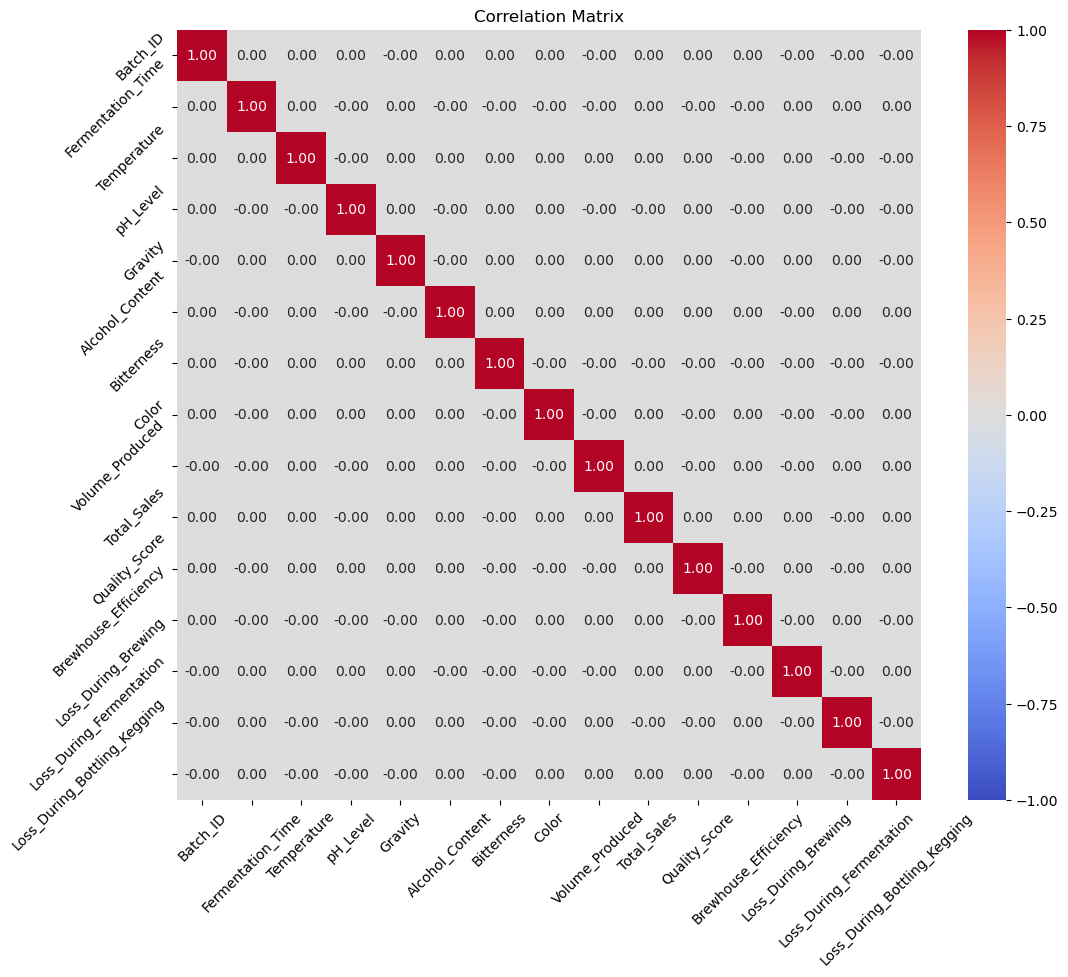

In [8]:
# Select only numerical columns
numeric_cols = [col for col in df.columns if dict(df.dtypes)[col] in ["int", "double"]]

# Assemble the numerical columns into a feature vector
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]
correlation_matrix = correlation_matrix.toArray()

# Convert the correlation matrix to a Pandas DataFrame for visualization
correlation_df = pd.DataFrame(correlation_matrix, index=numeric_cols, columns=numeric_cols)

# Display the correlation matrix
print(correlation_df)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

# Add title and labels
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [9]:
# Melt the correlation DataFrame to get variable pairs and their correlations
correlation_melted = correlation_df.reset_index().melt(id_vars='index')
correlation_melted.columns = ['Variable1', 'Variable2', 'Correlation']

# Remove self-correlations and duplicate pairs
correlation_melted = correlation_melted[correlation_melted['Variable1'] != correlation_melted['Variable2']]
correlation_melted['abs_correlation'] = correlation_melted['Correlation'].abs()

# Sort by the absolute value of the correlation and get the top 3
top_correlations = correlation_melted.sort_values(by='abs_correlation', ascending=False).drop_duplicates(subset=['abs_correlation']).head(5)

print("Top 3 Correlations:")
print(top_correlations[['Variable1', 'Variable2', 'Correlation']])

Top 3 Correlations:
         Variable1                     Variable2  Correlation
100  Quality_Score                    Bitterness    -0.001083
123       pH_Level               Volume_Produced    -0.001072
69     Total_Sales                       Gravity     0.000973
167    Temperature          Brewhouse_Efficiency    -0.000909
220  Quality_Score  Loss_During_Bottling_Kegging     0.000798


In [7]:

# Create a unique identifier for each row by concatenating all column values
unique_identifier = concat_ws("_", *df.columns)

# Add this unique identifier as a new column
df_with_id = df.withColumn("unique_id", unique_identifier)

# Group by the unique identifier and count the occurrences
duplicate_counts = df_with_id.groupBy("unique_id").count().filter(col("count") > 1)

# Count the number of duplicate rows
duplicate_count = duplicate_counts.count()

print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [4]:
from pyspark.sql.functions import avg

# Calculate average alcohol content and bitterness by beer style
avg_alcohol_bitterness = df.groupBy("Beer_Style") \
    .agg(avg("Alcohol_Content").alias("Avg_Alcohol_Content"),
         avg("Bitterness").alias("Avg_Bitterness"))

avg_alcohol_bitterness.show()


+----------+-------------------+------------------+
|Beer_Style|Avg_Alcohol_Content|    Avg_Bitterness|
+----------+-------------------+------------------+
|      Sour| 5.2491531262297935| 39.49474096011366|
|     Stout|  5.249933308740647| 39.49895418053473|
|     Lager|  5.249784868466295|39.489085474265394|
|    Porter|  5.249346408157073| 39.50792699151173|
|Wheat Beer|  5.250387548915359| 39.49387047088917|
|       Ale|  5.249538666096094| 39.50217868904124|
|       IPA|  5.249708373394683|  39.4835148509194|
|   Pilsner|  5.249506763557662|39.497950756419534|
+----------+-------------------+------------------+



In [5]:
# Calculate total sales by beer style
total_sales_by_style = df.groupBy("Beer_Style") \
    .sum("Total_Sales") \
    .withColumnRenamed("sum(Total_Sales)", "Total_Sales")

total_sales_by_style.show()


+----------+-------------------+
|Beer_Style|        Total_Sales|
+----------+-------------------+
|      Sour|9.178466054585724E9|
|     Stout|  9.1753483798313E9|
|     Lager|9.187083801668077E9|
|    Porter|9.193403267044203E9|
|Wheat Beer|9.181434698153645E9|
|       Ale| 9.20849385952654E9|
|       IPA|9.181481842569775E9|
|   Pilsner|9.187363007379778E9|
+----------+-------------------+



In [6]:
# Calculate average temperature and pH level by beer style
avg_temp_ph = df.groupBy("Beer_Style") \
    .agg(avg("Temperature").alias("Avg_Temperature"),
         avg("pH_Level").alias("Avg_pH_Level"))

avg_temp_ph.show()


+----------+------------------+------------------+
|Beer_Style|   Avg_Temperature|      Avg_pH_Level|
+----------+------------------+------------------+
|      Sour|20.003259926214675|4.9997397278157285|
|     Stout|  20.0029385369229| 4.999934842081013|
|     Lager|20.002217883583498| 5.000311129832931|
|    Porter|19.998768249667393| 4.999873611883576|
|Wheat Beer|  20.0022240443311| 4.999915308606895|
|       Ale|19.997779112049294|5.0001693804297425|
|       IPA| 19.99504533425316|4.9998242336909025|
|   Pilsner|19.998356985760527|4.9997201919364045|
+----------+------------------+------------------+



In [11]:
df.show(20)

+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+-------------------+------------------------+----------------------------+-----+---+----+--------+
|Batch_ID|          Brew_Date|Beer_Style|    SKU|       Location|Fermentation_Time|       Temperature|          pH_Level|           Gravity|  Alcohol_Content|Bitterness|Color|Ingredient_Ratio|Volume_Produced|       Total_Sales|    Quality_Score|Brewhouse_Efficiency|Loss_During_Brewing|Loss_During_Fermentation|Loss_During_Bottling_Kegging|Month|Day|Year|    Time|
+--------+-------------------+----------+-------+---------------+-----------------+------------------+------------------+------------------+-----------------+----------+-----+----------------+---------------+------------------+-----------------+--------------------+----

In [12]:
df.printSchema()

root
 |-- Batch_ID: integer (nullable = true)
 |-- Brew_Date: timestamp (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: integer (nullable = true)
 |-- Color: integer (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: integer (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Year: string 

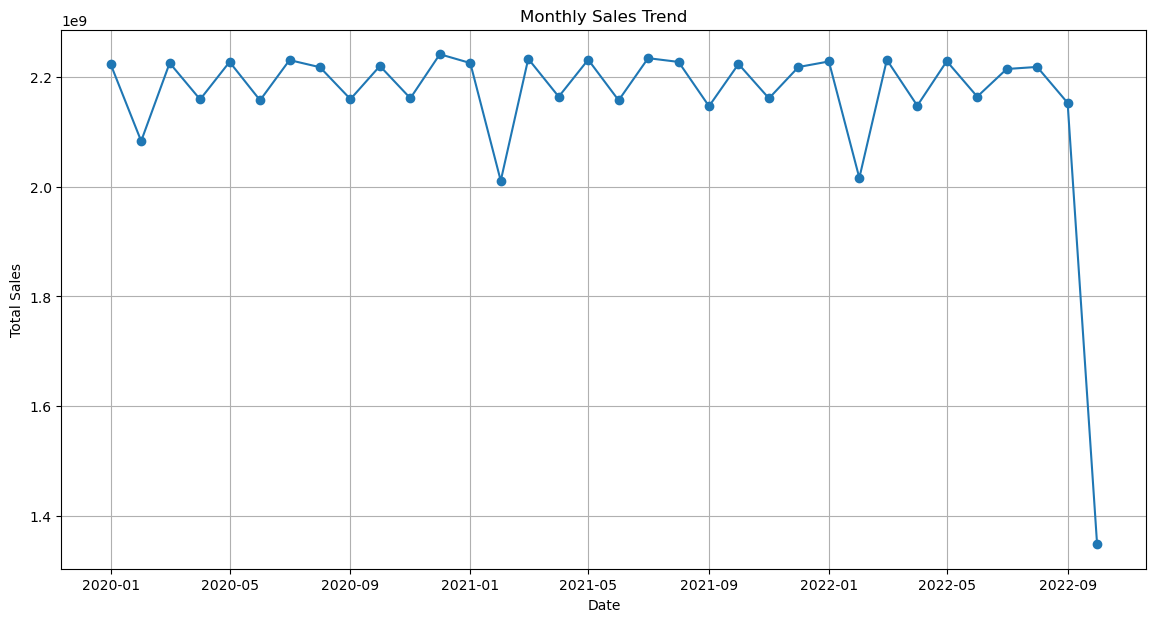

In [15]:
#Monthly sales

# Monthly Sales Trend
monthly_sales = df.groupBy("Year", "Month") \
    .agg(sum("Total_Sales").alias("Total_Sales")) \
    .orderBy("Year", "Month")

# Convert to Pandas DataFrame for visualization
monthly_sales_pd = monthly_sales.toPandas()

# Plot Monthly Sales Trend
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(monthly_sales_pd['Year'].astype(str) + '-' + monthly_sales_pd['Month'].astype(str)),
         monthly_sales_pd['Total_Sales'], marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

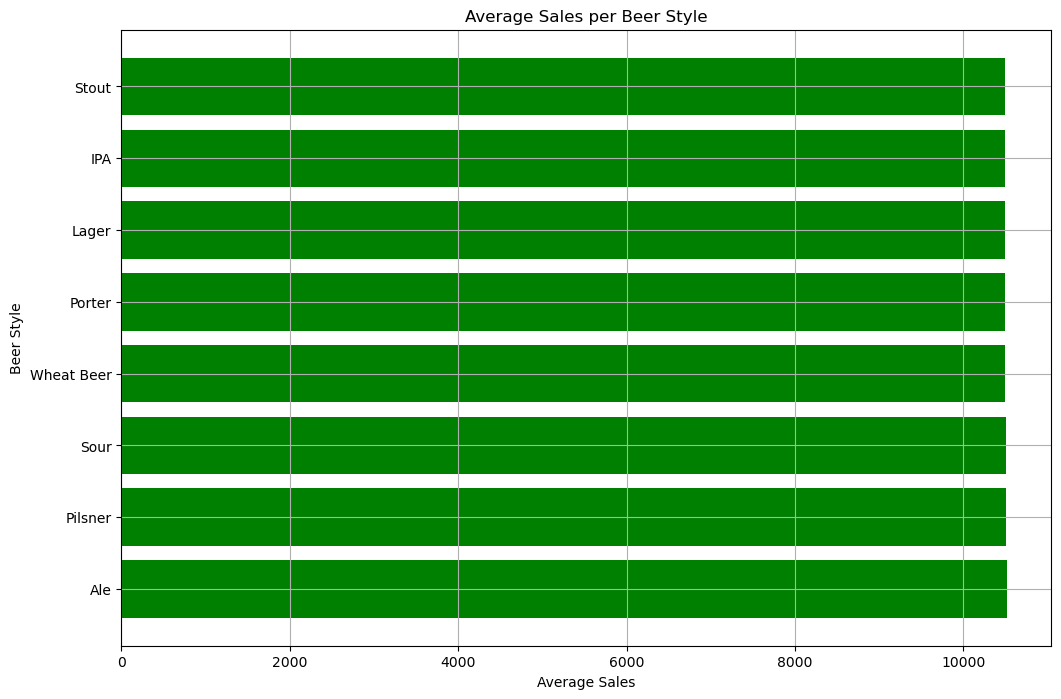

In [16]:
# Average Sales per Beer Style
avg_sales_per_style = df.groupBy("Beer_Style") \
    .agg(avg("Total_Sales").alias("Avg_Sales")) \
    .orderBy("Avg_Sales", ascending=False)

# Convert to Pandas DataFrame for visualization
avg_sales_per_style_pd = avg_sales_per_style.toPandas()

# Plot Average Sales per Beer Style
plt.figure(figsize=(12, 8))
plt.barh(avg_sales_per_style_pd['Beer_Style'], avg_sales_per_style_pd['Avg_Sales'], color='green')
plt.title('Average Sales per Beer Style')
plt.xlabel('Average Sales')
plt.ylabel('Beer Style')
plt.grid(True)
plt.show()


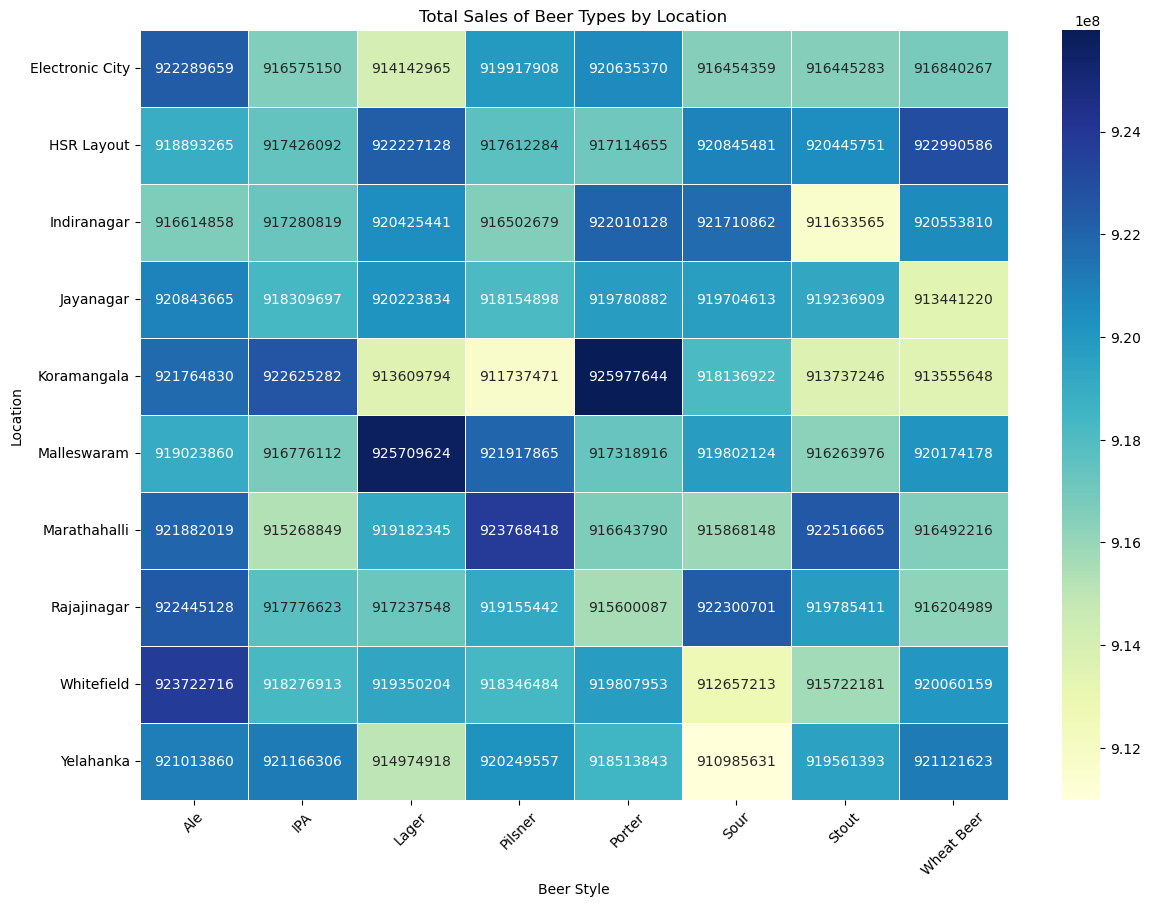

In [18]:
# Aggregate data by Beer_Style and Location, summing the Total_Sales
sales_by_type_location = df.groupBy("Beer_Style", "Location") \
    .agg(sum("Total_Sales").alias("Total_Sales")) \
    .orderBy("Beer_Style", "Location")

# Convert to Pandas DataFrame for visualization
sales_by_type_location_pd = sales_by_type_location.toPandas()

# Create a pivot table for better visualization
pivot_table = sales_by_type_location_pd.pivot(index='Location', columns='Beer_Style', values='Total_Sales')

# Plotting the data
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)
plt.title('Total Sales of Beer Types by Location')
plt.xlabel('Beer Style')
plt.ylabel('Location')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

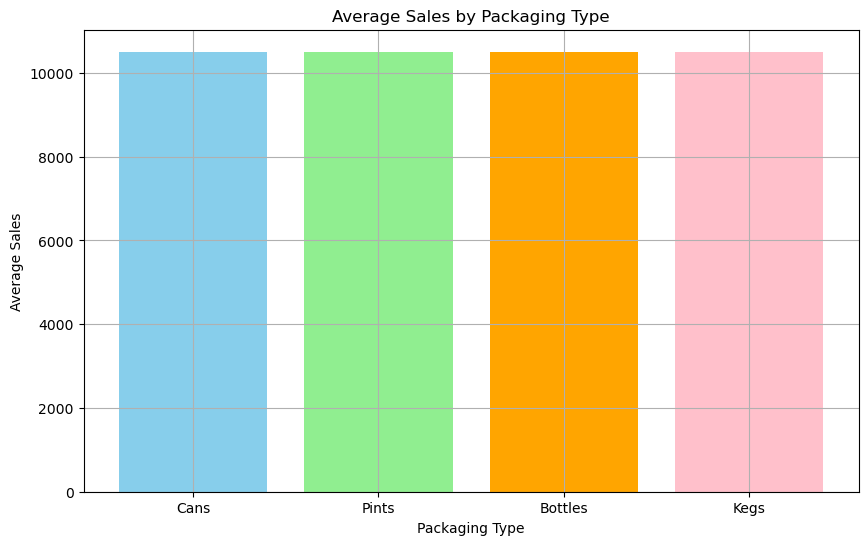

In [5]:
# Aggregate data by SKU, calculating the average Total_Sales
avg_sales_by_sku = df.groupBy("SKU") \
    .agg(avg("Total_Sales").alias("Avg_Sales")) \
    .orderBy("Avg_Sales", ascending=False)

# Convert to Pandas DataFrame for visualization
avg_sales_by_sku_pd = avg_sales_by_sku.toPandas()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(avg_sales_by_sku_pd['SKU'], avg_sales_by_sku_pd['Avg_Sales'], color=['skyblue', 'lightgreen', 'orange', 'pink'])
plt.title('Average Sales by Packaging Type')
plt.xlabel('Packaging Type')
plt.ylabel('Average Sales')
plt.grid(True)
plt.show()

In [3]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=["Fermentation_Time", "Temperature", "pH_Level", "Gravity", "Alcohol_Content", "Bitterness", "Color", "Volume_Produced", "Quality_Score", "Brewhouse_Efficiency", "Loss_During_Brewing", "Loss_During_Fermentation", "Loss_During_Bottling_Kegging"],
                            outputCol="features")

lr = LinearRegression(featuresCol="features", labelCol="Total_Sales")
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="Total_Sales", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

24/05/14 22:46:28 WARN Instrumentation: [0320801f] regParam is zero, which might cause numerical instability and overfitting.


Root Mean Squared Error (RMSE) on test data = 5490.815244842418


In [9]:
from pyspark.ml.regression import RandomForestRegressor
assembler = VectorAssembler(
    inputCols=["Fermentation_Time", "Temperature", "pH_Level", "Gravity", "Alcohol_Content", 
               "Bitterness", "Color", "Volume_Produced", "Quality_Score", 
               "Brewhouse_Efficiency", "Loss_During_Brewing", 
               "Loss_During_Fermentation", "Loss_During_Bottling_Kegging"],
    outputCol="features")


train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestRegressor(featuresCol="features", labelCol="Total_Sales")
pipeline = Pipeline(stages=[assembler, rf])

model = pipeline.fit(train_data)
predictions = model.transform(test_data)

predictions.select("prediction", "Total_Sales", "features").show(5)

evaluator = RegressionEvaluator(labelCol="Total_Sales", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

24/05/14 23:05:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+------------------+--------------------+
|        prediction|       Total_Sales|            features|
+------------------+------------------+--------------------+
|10503.000862143275| 5608.093834068051|[12.0,24.58145716...|
|10509.417649015977|  6436.80447593548|[17.0,21.69684900...|
|10507.361234414908| 13717.51932768758|[11.0,24.58601289...|
|10460.576131264635|14839.352279710096|[13.0,21.90986466...|
|10482.092454070294| 7820.054670655571|[17.0,24.87397672...|
+------------------+------------------+--------------------+
only showing top 5 rows



Root Mean Squared Error (RMSE) on test data = 5490.82


In [4]:
# Handle categorical columns (e.g., Beer_Style, SKU, Location)
categorical_cols = ['Beer_Style', 'SKU', 'Location']
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed") for col in categorical_cols]

In [5]:
# Assemble all features into a single vector column
feature_cols = ['Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 
                'Bitterness', 'Color', 'Volume_Produced', 'Brewhouse_Efficiency', 
                'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging'] + \
               [col+"_indexed" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [6]:
# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# Transform the data
df = pipeline.fit(df).transform(df)

# Select features and label
data = df.select(col("features"), col("Total_Sales").alias("label"))


In [7]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


In [8]:
# Convert Spark DataFrame to Pandas DataFrame for the aggregated result
train_pd = train_data.toPandas()
test_pd = test_data.toPandas()

# Separate features and labels for training and testing sets
X_train = train_pd['features'].apply(lambda x: pd.Series(x.toArray())).values
y_train = train_pd['label'].values
X_test = test_pd['features'].apply(lambda x: pd.Series(x.toArray())).values
y_test = test_pd['label'].values


24/05/14 23:22:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
ERROR:root:Exception while sending command.                                     
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkE

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
import xgboost as xgb

# Train the XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

bst = xgb.train(params, dtrain, num_boost_round=100)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
predictions = bst.predict(dtest)

# Evaluate the model
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")


In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Actual Total Sales")
plt.ylabel("Predicted Total Sales")
plt.title("Actual vs. Predicted Total Sales")
plt.show()
